In [80]:
using Pkg,Statistics,Random,Printf,GZip,Knet,Plots,LinearAlgebra,Distributions,StatsBase, Interact

## Generate training data

In [2]:
Random.seed!(1);
Range=3.0; # range of the x values for the target Gaussian function
Incr = 0.03; # Number of training examples = 3.0/0.03 = 100
Noise_std=0.1; # add noise on the Gaussian function

In [3]:
# generate the data from which we'll learn the Gaussian function
# obligatory arguments listed before ";" while optional arguments come after ";".
function gen_noisy_gaussian(;range=1.0,noise=0.1)
    x = collect(-Range:Incr:Range)
    y = exp.(-x.^2) + randn(length(x))*noise; # additive gaussian noise
    return (x,y)
end
# output is two vectors x,y

gen_noisy_gaussian (generic function with 1 method)

In [4]:
(x_train,y_train) = gen_noisy_gaussian(range=Range,noise=Noise_std);
pop!(x_train);pop!(y_train);

In [5]:
Ntrain =length(x_train) # number of training data points

200

## Network + loss function

In [6]:
Batchsize = 10; # determines the degree of batch noise (smaller batchsize => larger noise)
RegWeight=0.001; # lambda for L2 regularization - sets the minimum of the Hessian eigenvalues
InitNorm = 0.5; # initial weight norm - not critical

In [7]:
Nweights = 7;

In [8]:
function predict(w,x) # returns a row of predicted values for each sample in x
    return w[5:6]'*tanh.(w[1:2]*x' .+ w[3:4]) .+ w[7]
end

predict (generic function with 1 method)

In [9]:
# both x and y are ordered in columns per training data point
function sqloss(w,x,y)
    return mean(abs2,y'-predict(w,x))
end

function reg(w)
    return RegWeight*norm(w)^2
end

function loss(w,x,y)
    return sqloss(w,x,y) + reg(w)
end

loss (generic function with 1 method)

## Gradient

In [10]:
# grad() is a "functional" whose input and output is a function (loss). 
# The output function takes the same arguments as the input function.
# Requires input to be a scalar function and evaluates the gradient wrt elements of the first argument.
# Let ∇f = grad(f). f = f(x,y,z) => ∇f(x,y,z) = ∇ₓf with identical structure as x
lossgradient = grad(loss)
sqlossgradient = grad(sqloss)
reggradient = grad(reg)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(reg),Int64,Bool}}) (generic function with 1 method)

In [11]:
# calculate gradient at the initial w
# dw has dimensions of w: each weight wᵢ is replaced with the ∂/∂wᵢ
Random.seed!(2);
@show w = randn(Nweights)
dw = lossgradient(w,x_train,y_train);

w = randn(Nweights) = [0.739621, -0.744507, -0.608508, -1.72346, -0.675616, 0.556646, -0.861584]


## Training function (with replacement)

In [12]:
function batchtrain!(w,lr)
perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
x = [x_train[n] for n in perm]
y = [y_train[n] for n in perm]
# calculate gradient over the batch
dw = lossgradient(w,x,y);
#update weights
    w .-= lr*dw # "." does broadcasting. `this is the same as for i=1:Nweights w[i] -= lr*dw[i] end
return w
end

batchtrain! (generic function with 1 method)

## Initial training run

In [13]:
w = rand(Nweights); w/= norm(w)/InitNorm
Nmarkov = 10000; # For a quick training run
η = 0.01; # Learning rate

In [14]:
# Initial run - trajectory stored in w_training
w_training = zeros(Nweights,Nmarkov)
time0 = time()
for n = 1:Nmarkov
    w_training[:,n] = batchtrain!(w,η)
end
time()-time0

2.604055881500244

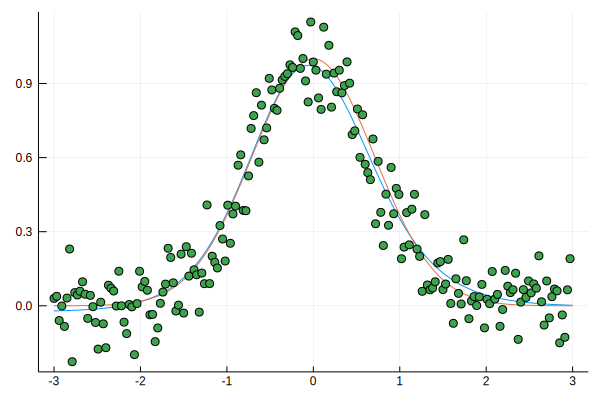

In [15]:
# Checking if the training worked. Compare the learned function with the actual gaussian
xplot=collect(-Range:0.01:Range)
# plot the converged function, the initial gaussian and the noisy training samples
plot(xplot,[predict(w,xplot)',exp.(-xplot.^2)]);
scatter!(x_train,y_train,leg=false)

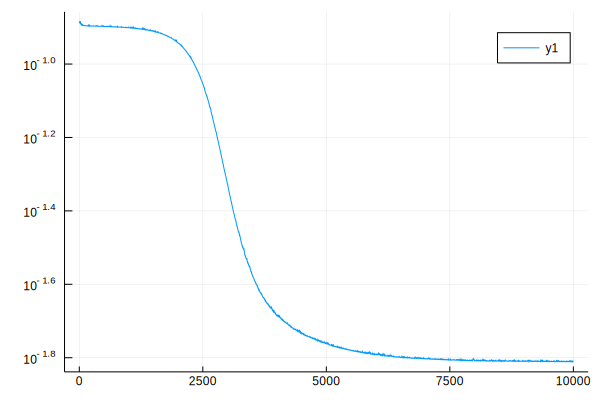

In [16]:
# Plot loss
SamplingRate=min(1,div(Nmarkov,1000));
x = collect(1:SamplingRate:Nmarkov);
y = [loss(w_training[:,i],x_train,y_train) for i in x];
#plot(x,y)
plot(x,y
#    ,xaxis=:log10
    ,yaxis=:log10
    ) # can also plot in log-log scale

## Diffusion, Hessian, Covariance Matrices

In [17]:
function diffusionmatrix(w,xt,yt,Nb,lr)
    Nweights = length(w) # number of weights, that is, dimensions of the diffusion tensor
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    V = zeros(Nweights,Nt) # initialize the diffusion matrix
    for i=1:Nt
        x=xt[i]
        y=yt[i]
        V[:,i] = lossgradient(w,[x],[y])
    end
    V /= Nt;
    dL = sqlossgradient(w,xt,yt);
    
    return lr^2 * prefac * (Nt*V*V' - dL*dL')
end

diffusionmatrix (generic function with 1 method)

In [18]:
# Calculate the diffusion tensor by sampling the noise
function diffusionmatrix_num(w,n,lr) # n: number of samples used for estimation
    wlist = zeros(Nweights,n)
    
    for i=1:n
        ww = copy(w)       
        wlist[:,i] = batchtrain!(ww,lr)
    end

    # subtract mean
    wlist .-= sum(wlist[:,i] for i=1:n)/n

    D = zeros(Nweights,Nweights)
    for α=1:Nweights
        for β=1:Nweights
            for i=1:n
                D[α,β] += wlist[α,i]*wlist[β,i]
            end
            D[α,β] /= n;
        end
    end
    return 0.5*D
end

diffusionmatrix_num (generic function with 1 method)

In [19]:
# To calculate the Hessian, define a scalar function returning ∂L/∂wⱼ
function lossgradj(w,x,y,j)
    return lossgradient(w,x,y)[j]
end

lossgradj (generic function with 1 method)

In [20]:
# Define the function returning ∂²L/∂wᵢ∂wⱼ for all i, given j (a column of the Hessian)
lossgradgrad = grad(lossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(lossgradj),Int64,Bool}}) (generic function with 1 method)

In [21]:
function hessianmatrix(w,x,y)
    Nw = length(w);
    Hess = zeros(Nw,Nw);
    for j=1:Nw
        Hess[:,j] = lossgradgrad(w,x,y,j)
    end
    return Hess
end

hessianmatrix (generic function with 1 method)

In [22]:
# This calculation is from Michael's overleaf notes:
# https://www.overleaf.com/2523873322bvvnxpwnskfk
function covariancematrix(D,H,lr) # is a function of the learning rate
    F = eigen(H);
    h = F.values
    O = F.vectors
    Nw = length(h)
    ODO = O'*D*O;
    Delta = zeros(Nw,Nw);
    for i=1:Nw
        for j=1:Nw
            Delta[i,j] = ODO[i,j]/(h[i]+h[j])
        end
    end
    return (2/lr)*O*Delta*O'
end

covariancematrix (generic function with 1 method)

### Use Newton's Method to find the minimum of loss

In [23]:
# Using Newton's method get the the true minimum of the full loss function
w = w_training[:,end];
# implement Newton's method to find the true minimum. 4 steps are enough!
for n=1:10
    Hess = hessianmatrix(w,x_train,y_train)
    gradw = lossgradient(w,x_train,y_train)
    dw = inv(Hess)*gradw
    for i=1:Nweights
        w[i] -= dw[i]
    end
end
wmin = w[:,1]

7-element Array{Float64,1}:
  1.2863560700651808  
  1.1850177733330083  
  0.7216320599019037  
 -0.5095749741748058  
  0.9184498728752972  
 -0.9027273944837443  
 -0.010323317556957813

In [24]:
lossgradient(wmin,x_train,y_train)

7-element Array{Float64,1}:
 -1.734723475976807e-17 
  1.474514954580286e-17 
  1.4094628242311558e-17
  9.540979117872439e-18 
 -2.211772431870429e-17 
 -3.122502256758253e-17 
 -3.3949080525952358e-18

### Hessian at the loss minimum

In [25]:
Hessmin = hessianmatrix(wmin,x_train,y_train);

### Diffusion tensor at the loss minimum

In [26]:
# diffusion tensor at the loss minimum (using VV')
Dmin = diffusionmatrix(wmin,x_train,y_train,Batchsize,η);

In [27]:
# compare with D calculated numerically
Dmin_num = diffusionmatrix_num(wmin,10000,η);
#Dmin_num ./ Dmin

In [28]:
@show isapprox(Dmin_num,Dmin, rtol=0.01)
@show isapprox(Dmin_num,Dmin, rtol=0.02)

isapprox(Dmin_num, Dmin, rtol=0.01) = false
isapprox(Dmin_num, Dmin, rtol=0.02) = true


true

### Covariance matrix as a function of Hessian and Diffusion matrix

In [29]:
Covmin = covariancematrix(Dmin,Hessmin,η);

In [30]:
# verify that the math is right: HC+CH = (2/η)D
norm(Hessmin*Covmin + Covmin*Hessmin - (2/η)*Dmin) # should be zero

9.924173799576777e-20

## Steady state

In [31]:
Random.seed!(1)
Nmarkov = 10^7; # number of Markov steps

In [32]:
w = copy(wmin); # start from the minimum of the potential

In [33]:
fname = "Gaussian_wr_ss-$Nmarkov-$η.jld2"
if !isfile(fname)
    w_ss = zeros(Nweights,Nmarkov)
    time0 = time() # takes about an hour for Nmarkov = 10^7
    for n = 1:Nmarkov
        w_ss[:,n] = batchtrain!(w,η)
    end
    @show time()-time0
    Knet.save(fname, "w_ss", w_ss)
    else
        w_ss = Knet.load(fname, "w_ss");
    end
@show summary(w_ss)

summary(w_ss) = "7×10000000 Array{Float64,2}"


"7×10000000 Array{Float64,2}"

### Fit a Mv-Gaussian to the equilibrium data

In [34]:
Fit_ss = fit_mle(MvNormal,w_ss)

FullNormal(
dim: 7
μ: [1.28659, 1.185, 0.72205, -0.509812, 0.918041, -0.902316, -0.0103062]
Σ: [7.36541e-6 3.36126e-7 … -5.10219e-7 -2.96368e-7; 3.36126e-7 7.91925e-6 … -1.16729e-6 -3.25431e-7; … ; -5.10219e-7 -1.16729e-6 … 6.56006e-6 -6.67475e-7; -2.96368e-7 -3.25431e-7 … -6.67475e-7 9.27504e-6]
)


### Steady-state mean


In [35]:
wmean = Distributions.mean(Fit_ss)

7-element Array{Float64,1}:
  1.2865894047547268  
  1.1850043210377585  
  0.7220497299931339  
 -0.5098122231702785  
  0.918041012941426   
 -0.9023163365760021  
 -0.010306188349074387

In [36]:
norm(wmean-wmin)/norm(wmin)

0.0003362951200872646

### Covariance matrix (from ss-trajectory)

In [37]:
Cov_ss = Distributions.cov(Fit_ss)

7×7 Array{Float64,2}:
  7.36541e-6   3.36126e-7  -2.33575e-6  -6.41977e-7   1.01328e-6  -5.10219e-7  -2.96368e-7
  3.36126e-7   7.91925e-6   5.27349e-7   1.97085e-6   7.27997e-7  -1.16729e-6  -3.25431e-7
 -2.33575e-6   5.27349e-7   6.1838e-6    4.14821e-7   1.74016e-6  -1.81144e-6   2.61679e-7
 -6.41977e-7   1.97085e-6   4.14821e-7   6.35546e-6  -2.40279e-6   2.09418e-6  -4.62711e-7
  1.01328e-6   7.27997e-7   1.74016e-6  -2.40279e-6   6.81396e-6   2.47635e-6  -1.50289e-7
 -5.10219e-7  -1.16729e-6  -1.81144e-6   2.09418e-6   2.47635e-6   6.56006e-6  -6.67475e-7
 -2.96368e-7  -3.25431e-7   2.61679e-7  -4.62711e-7  -1.50289e-7  -6.67475e-7   9.27504e-6

In [38]:
# Compare with the solution of ΣH + HΣ = (2/η)D
norm(Covmin-Cov_ss)/norm(Covmin)

0.033762789991018255

### Move to the eigen-coordinates

In [39]:
# pick two eigen directions
Xid,Yid = Nweights,Nweights-1
O = eigvecs(Cov_ss);
Λ = eigvals(Cov_ss);

W_ss = O'*w_ss; # sample weights are row vectors
Wx = W_ss[Xid,:]
Wy = W_ss[Yid,:]

COV_ss = O'*Cov_ss*O # by construction diagonal
COV_xy_inv = inv(COV_ss[[Xid,Yid],[Xid,Yid]]) # this must be Diag(λx,λy)

Wmean = O'*wmean
Wmin = O'*wmin;

In [40]:
# COV_xy_inv = Diag(λx,λy)
norm(COV_xy_inv - Diagonal([1/Λ[Xid],1/Λ[Yid]]))

5.214702937753598e-11

## Integral Fluctuation Theorem

In [41]:
## Move origin to the distribution mean
for i=1:Nmarkov
    W_ss[:,i] -= Wmean
end

In [42]:
# coarse grain the parameter space: each "quadrant" is a single state
function state(x)
    s = 1;
    for i=1:length(x)
        if (sign(x[i])>0)
            s += 2^(i-1)
        end
    end
    return s
end

# the trajectory for states
traj = zeros(Int,Nmarkov)
for i=1:Nmarkov
    traj[i] = state(W_ss[:,i])
end

In [43]:
# Calculate the ss transition matrix and the ss probability vector
W = zeros(2^Nweights,2^Nweights)
p = zeros(2^Nweights)
for i=1:Nmarkov-1
    W[traj[i+1],traj[i]] += 1
    p[traj[i]] += 1
end
W /= Nmarkov
p /= Nmarkov;

In [44]:
# check that the fluctuations in the probability vector are not sampling noise
# (if so, the magnitude of percentage fluctuations would be of order 1/√N)
mean(p),std(p)/mean(p),sqrt(length(p)/Nmarkov)

(0.007812499218750002, 0.04516698187258382, 0.0035777087639996636)

In [45]:
# Calculate the irreversible entropy produced: ΔSⁱ
function deltaS(sampletraj)
    ΔS=0
    for i=1:length(sampletraj)-1
        ni,nim1 = sampletraj[i+1],sampletraj[i]
        if (W[nim1,ni]>0)
            ΔS += log((W[ni,nim1]*p[nim1])/(W[nim1,ni]*p[ni]))
        end
    end
    return ΔS
end

deltaS (generic function with 1 method)

In [46]:
# Divide the ss-trajectory into independent shorter trajectories
# and calculate ΔSⁱ for each
samplelen=10^2
nsamples = div(Nmarkov,samplelen)
dSs = zeros(nsamples)
for n in progress(1:nsamples)
    dSs[n] = deltaS(traj[(n-1)*samplelen+1:n*samplelen])
end

1.00e+05  100.00%┣███████████████████████████████████████████████████████████┫ 100000/100000 [00:03/00:03, 28592.59i/s]


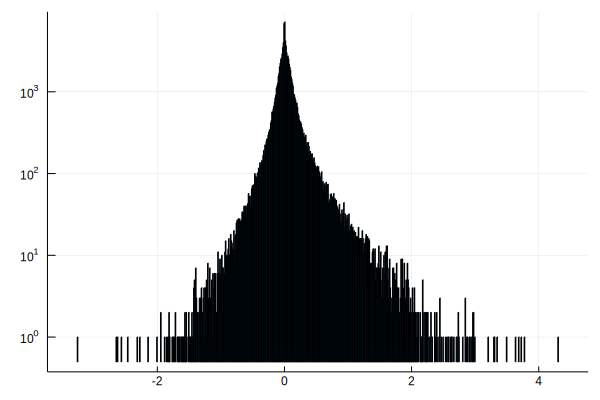

In [137]:
# check that the distribution of ΔSⁱ around zero is asymmetric
histogram(dSs
    ,yaxis=:log
    ,legend=:false
#    ,bins=-2.5:0.05:2.5
)

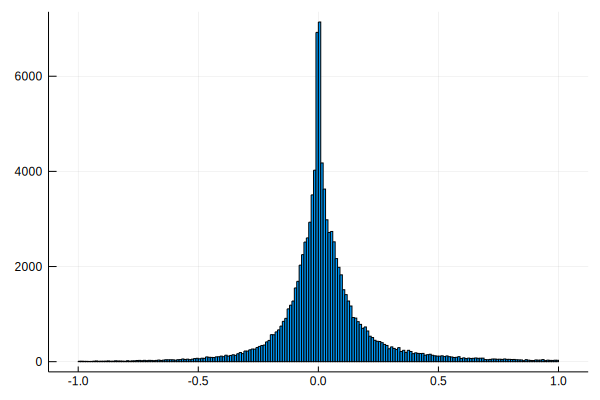

In [66]:
# check that the distribution of ΔSⁱ around zero is asymmetric
histogram(dSs
#    ,yaxis=:log
    ,legend=:false
    ,bins=-1:0.01:1
)

In [63]:
# Verify the IFT
sum(exp.(-dSs))/nsamples

0.9937613599960683

In [79]:
dSs

100000-element Array{Float64,1}:
 -0.48441105007077956  
  0.17556352525439992  
  0.0051214252534555645
 -0.03511772528673914  
  0.05797402069659972  
  0.06370873369314001  
  0.02326755669533466  
  0.6704714309663153   
  0.27065898104247044  
 -0.08143875067469987  
  0.05729023063681988  
 -0.003966475166092236 
 -0.1009668451710456   
  ⋮                    
  0.3743710569934603   
  0.33579769807616555  
 -0.039639631942197946 
  0.08068720566150438  
 -0.26957400884063615  
  0.23329408084270603  
 -0.046432318481307445 
  0.12679712299395787  
  0.0008035186777165387
  0.7727798985623311   
 -0.3092582920859706   
  0.08344517837735675  

In [164]:
histrange = -4.05:0.1:4.05
fith = fit(Histogram,dSs,histrange)
my_y = fith.weights # bin counts
pΔS = my_y/sum(my_y) # normalize
my_range = collect(histrange)
nhist = length(pΔS)
ΔS = [0.5*(my_range[i]+my_range[i+1]) for i=1:nhist]
@show length(ΔS),length(pΔS)

(length(ΔS), length(pΔS)) = (81, 81)


(81, 81)

In [162]:
# my_ratio = log.([my_y[i]/my_y[nhist-i+1] for i=1:nhist]);

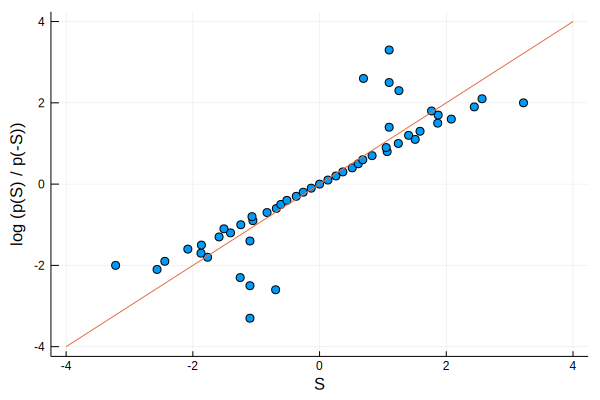

In [140]:
# scatter(my_ratio,my_x,xaxis="S",yaxis="log (p(S) / p(-S))",legend=:false)
# f(x)=x
# plot!(my_x,f.(my_x))

In [141]:
index_zero = div(nhist,2)+1

41

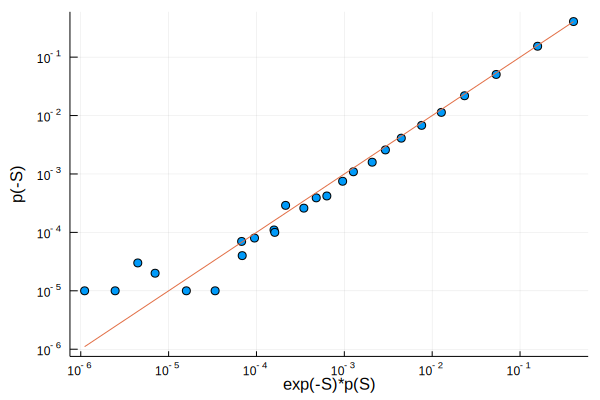

In [165]:
rhs = [exp(-ΔS[i])*pΔS[i] for i=index_zero:nhist]
lhs = [pΔS[nhist-i+1] for i=index_zero:nhist]
xvals = [rhs[1]]; yvals = [lhs[1]]
for i=2:length(lhs)
    if (rhs[i]>0 && lhs[i]>0)
        push!(xvals,rhs[i])
        push!(yvals,lhs[i])
    end
end
scatter(xvals,yvals,legend=:false,xaxis=:log,yaxis=:log)
f(x)=x
plot!(xvals,f.(xvals),xaxis="exp(-S)*p(S)",yaxis="p(-S)")